In [9]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [14]:
import os
from torchvision import datasets , transforms
from torch.utils.data import DataLoader

# chemin vers le dataset
base_dir = "."

# Transformations
transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3 , std=[0.5]*3)
    ]
)

# Dataset
train_dataset = datasets.ImageFolder(os.path.join(base_dir,"train") , transform = transform)
test_dataset = datasets.ImageFolder(os.path.join(base_dir,"test") , transform = transform)

# DataLoader
train_loader = DataLoader(train_dataset , batch_size = 16 , shuffle=True , num_workers = 4)
test_loader = DataLoader(train_dataset , batch_size = 16 , shuffle=False , num_workers = 4)

# Vérification
print(f"Nombre de classes : {len(train_dataset.classes)}")
print("Exemples de classes :" , train_dataset.classes[:5])

Nombre de classes : 23
Exemples de classes : ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections']


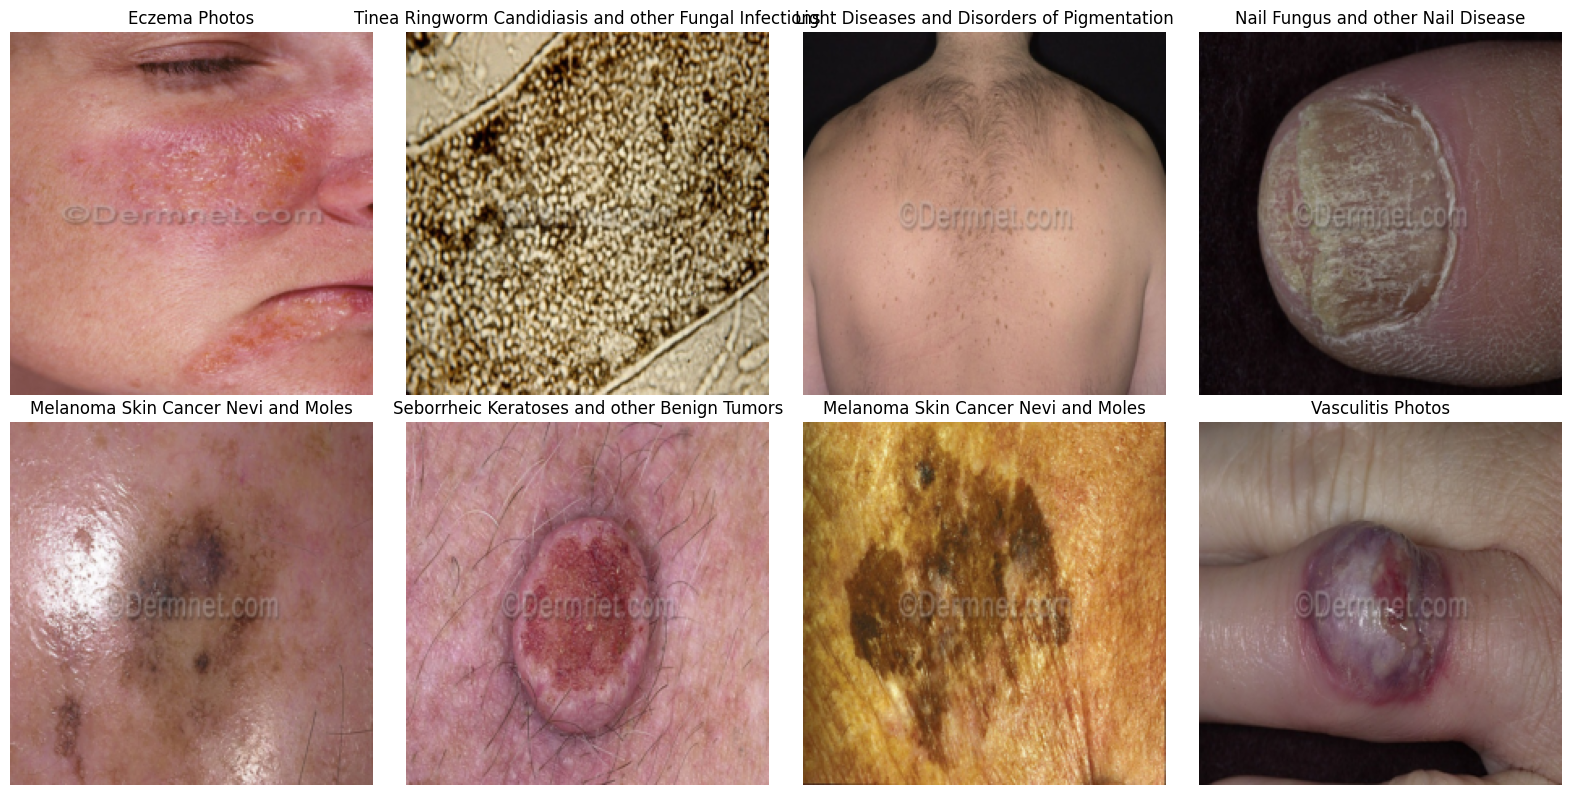

In [3]:
import matplotlib.pyplot as plt

# Récupérer un batch
images, labels = next(iter(train_loader))

# Taille de la figure
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Affichage des images
for img, label, ax in zip(images[:8], labels[:8], axes):
    img = img.permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
    img = img * 0.5 + 0.5       # dé-normalisation
    ax.imshow(img)
    ax.set_title(train_dataset.classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()


In [4]:
import timm
import torch
import torch.nn as nn

# Détection du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Nombre de classes
num_classes = len(train_dataset.classes)

# Chargement du modèle ViT préentraîné
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Remplacer la classification head
model.head = nn.Linear(model.head.in_features, num_classes)

# Freeze tous les paramètres
for param in model.parameters():
    param.requires_grad = False

# Unfreeze les derniers blocs, norm et head
for name, param in model.named_parameters():
    if any(layer in name for layer in [f'blocks.{i}' for i in range(2, 12)] + ['norm', 'head']):
        param.requires_grad = True

model = model.to(device)

# Fonction corrigée : LLRD sans doublons
def get_layerwise_lr_decay(model, base_lr=1e-4, decay=0.9):
    param_groups = []
    used_params = set()
    num_blocks = len(model.blocks)

    for i in range(num_blocks):
        lr = base_lr * (decay ** (num_blocks - i - 1))
        params = [p for n, p in model.named_parameters()
                  if f'blocks.{i}' in n and p.requires_grad and id(p) not in used_params]
        used_params.update(map(id, params))
        if params:
            param_groups.append({'params': params, 'lr': lr})

    head_params = [p for n, p in model.named_parameters()
                   if ('head' in n or 'norm' in n) and p.requires_grad and id(p) not in used_params]
    if head_params:
        param_groups.append({'params': head_params, 'lr': base_lr})
        used_params.update(map(id, head_params))

    return param_groups

# Optimiseur avec LLRD
optimizer = torch.optim.AdamW(get_layerwise_lr_decay(model), weight_decay=0.01)

# Affichage des paramètres entraînables
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Trainable params: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")


✅ Trainable params: 70,904,087 / 85,816,343 (82.62%)


In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [6]:
print(model)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [7]:

import torch.nn as nn
from sklearn.metrics import accuracy_score

# Fonction de perte (standard pour classification multi-classes)
criterion = nn.CrossEntropyLoss()

# Fonction de calcul d'accuracy
def compute_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    return (predicted == labels).sum().item() / labels.size(0)


In [8]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Entraînement
def train(model, train_loader, optimizer, criterion, device, epochs=10 , save_path="best_train_model.pth"):
    best_train_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(enumerate(train_loader), total=len(train_loader),
                    desc=f"[Epoch {epoch+1}/{epochs}]", ncols=120)

        for batch_idx, (images, labels) in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Stats
            batch_loss = loss.item()
            preds = outputs.argmax(1)
            batch_acc = (preds == labels).sum().item() / labels.size(0)
            running_loss += batch_loss
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # LR
            current_lr = optimizer.param_groups[0]['lr']

            # Progress bar update
            loop.set_postfix_str(
                f"batch_loss={batch_loss:.4f} | batch_acc={batch_acc*100:.2f}% | "
                f"avg_acc={100 * correct / total:.2f}% | lr={current_lr:.1e}"
            )

        avg_epoch_loss = running_loss / len(train_loader)
        print(f"✅ Epoch {epoch+1} done — Train Loss: {avg_epoch_loss:.4f} | Train Acc: {100 * correct / total:.2f}%")

        if avg_epoch_loss < best_train_loss:
            best_train_loss = avg_epoch_loss
            torch.save(model.state_dict(), save_path)
            print(f"💾 Best model saved (loss={best_train_loss:.4f}) → {save_path}")


In [9]:
train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=20,
    save_path="best_train_model.pth" 
)


[Epoch 1/20]: 100%|█| 973/973 [08:36<00:00,  1.88it/s, batch_loss=1.4491 | batch_acc=60.00% | avg_acc=42.76% | lr=3.1e-0


✅ Epoch 1 done — Train Loss: 1.9290 | Train Acc: 42.76%
💾 Best model saved (loss=1.9290) → best_train_model.pth


[Epoch 2/20]: 100%|█| 973/973 [08:31<00:00,  1.90it/s, batch_loss=0.3261 | batch_acc=100.00% | avg_acc=69.36% | lr=3.1e-


✅ Epoch 2 done — Train Loss: 1.0112 | Train Acc: 69.36%
💾 Best model saved (loss=1.0112) → best_train_model.pth


[Epoch 3/20]: 100%|█| 973/973 [08:54<00:00,  1.82it/s, batch_loss=0.1419 | batch_acc=100.00% | avg_acc=85.30% | lr=3.1e-


✅ Epoch 3 done — Train Loss: 0.4618 | Train Acc: 85.30%
💾 Best model saved (loss=0.4618) → best_train_model.pth


[Epoch 4/20]: 100%|█| 973/973 [08:43<00:00,  1.86it/s, batch_loss=0.4503 | batch_acc=80.00% | avg_acc=91.14% | lr=3.1e-0


✅ Epoch 4 done — Train Loss: 0.2676 | Train Acc: 91.14%
💾 Best model saved (loss=0.2676) → best_train_model.pth


[Epoch 5/20]: 100%|█| 973/973 [08:59<00:00,  1.80it/s, batch_loss=0.0242 | batch_acc=100.00% | avg_acc=92.77% | lr=3.1e-


✅ Epoch 5 done — Train Loss: 0.2122 | Train Acc: 92.77%
💾 Best model saved (loss=0.2122) → best_train_model.pth


[Epoch 6/20]: 100%|█| 973/973 [08:31<00:00,  1.90it/s, batch_loss=0.7085 | batch_acc=60.00% | avg_acc=93.52% | lr=3.1e-0


✅ Epoch 6 done — Train Loss: 0.1873 | Train Acc: 93.52%
💾 Best model saved (loss=0.1873) → best_train_model.pth


[Epoch 7/20]: 100%|█| 973/973 [08:36<00:00,  1.88it/s, batch_loss=0.0028 | batch_acc=100.00% | avg_acc=94.28% | lr=3.1e-


✅ Epoch 7 done — Train Loss: 0.1615 | Train Acc: 94.28%
💾 Best model saved (loss=0.1615) → best_train_model.pth


[Epoch 8/20]: 100%|█| 973/973 [08:40<00:00,  1.87it/s, batch_loss=0.2663 | batch_acc=80.00% | avg_acc=93.73% | lr=3.1e-0


✅ Epoch 8 done — Train Loss: 0.1723 | Train Acc: 93.73%


[Epoch 9/20]: 100%|█| 973/973 [08:38<00:00,  1.88it/s, batch_loss=0.1475 | batch_acc=100.00% | avg_acc=94.54% | lr=3.1e-


✅ Epoch 9 done — Train Loss: 0.1475 | Train Acc: 94.54%
💾 Best model saved (loss=0.1475) → best_train_model.pth


[Epoch 10/20]: 100%|█| 973/973 [08:40<00:00,  1.87it/s, batch_loss=0.1604 | batch_acc=100.00% | avg_acc=94.72% | lr=3.1e


✅ Epoch 10 done — Train Loss: 0.1371 | Train Acc: 94.72%
💾 Best model saved (loss=0.1371) → best_train_model.pth


[Epoch 11/20]: 100%|█| 973/973 [08:40<00:00,  1.87it/s, batch_loss=0.2406 | batch_acc=80.00% | avg_acc=94.62% | lr=3.1e-


✅ Epoch 11 done — Train Loss: 0.1378 | Train Acc: 94.62%


[Epoch 12/20]: 100%|█| 973/973 [08:36<00:00,  1.88it/s, batch_loss=0.1393 | batch_acc=100.00% | avg_acc=95.26% | lr=3.1e


✅ Epoch 12 done — Train Loss: 0.1253 | Train Acc: 95.26%
💾 Best model saved (loss=0.1253) → best_train_model.pth


[Epoch 13/20]: 100%|█| 973/973 [08:26<00:00,  1.92it/s, batch_loss=0.0065 | batch_acc=100.00% | avg_acc=95.23% | lr=3.1e


✅ Epoch 13 done — Train Loss: 0.1220 | Train Acc: 95.23%
💾 Best model saved (loss=0.1220) → best_train_model.pth


[Epoch 14/20]: 100%|█| 973/973 [08:26<00:00,  1.92it/s, batch_loss=0.0023 | batch_acc=100.00% | avg_acc=95.22% | lr=3.1e


✅ Epoch 14 done — Train Loss: 0.1178 | Train Acc: 95.22%
💾 Best model saved (loss=0.1178) → best_train_model.pth


[Epoch 15/20]: 100%|█| 973/973 [08:26<00:00,  1.92it/s, batch_loss=0.2636 | batch_acc=80.00% | avg_acc=95.03% | lr=3.1e-


✅ Epoch 15 done — Train Loss: 0.1212 | Train Acc: 95.03%


[Epoch 16/20]: 100%|█| 973/973 [08:26<00:00,  1.92it/s, batch_loss=0.0380 | batch_acc=100.00% | avg_acc=95.66% | lr=3.1e


✅ Epoch 16 done — Train Loss: 0.1033 | Train Acc: 95.66%
💾 Best model saved (loss=0.1033) → best_train_model.pth


[Epoch 17/20]: 100%|█| 973/973 [08:26<00:00,  1.92it/s, batch_loss=0.0005 | batch_acc=100.00% | avg_acc=95.22% | lr=3.1e


✅ Epoch 17 done — Train Loss: 0.1163 | Train Acc: 95.22%


[Epoch 18/20]: 100%|█| 973/973 [08:26<00:00,  1.92it/s, batch_loss=0.8216 | batch_acc=60.00% | avg_acc=95.73% | lr=3.1e-


✅ Epoch 18 done — Train Loss: 0.1057 | Train Acc: 95.73%


[Epoch 19/20]: 100%|█| 973/973 [08:27<00:00,  1.92it/s, batch_loss=0.0001 | batch_acc=100.00% | avg_acc=95.51% | lr=3.1e


✅ Epoch 19 done — Train Loss: 0.1101 | Train Acc: 95.51%


[Epoch 20/20]: 100%|█| 973/973 [08:26<00:00,  1.92it/s, batch_loss=0.6427 | batch_acc=60.00% | avg_acc=95.73% | lr=3.1e-


✅ Epoch 20 done — Train Loss: 0.0965 | Train Acc: 95.73%
💾 Best model saved (loss=0.0965) → best_train_model.pth


## Testing

In [11]:
def evaluate_model(model, test_loader, criterion, device, weights_path="best_train_model.pth"):
    # Charger les poids sauvegardés
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", ncols=100):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total

    print(f"\n✅ Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")


In [12]:
evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    weights_path="best_train_model.pth"
)


Testing: 100%|████████████████████████████████████████████████████| 973/973 [03:05<00:00,  5.23it/s]


✅ Test Loss: 0.0754 | Test Accuracy: 96.72%


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

## Confusion matrix

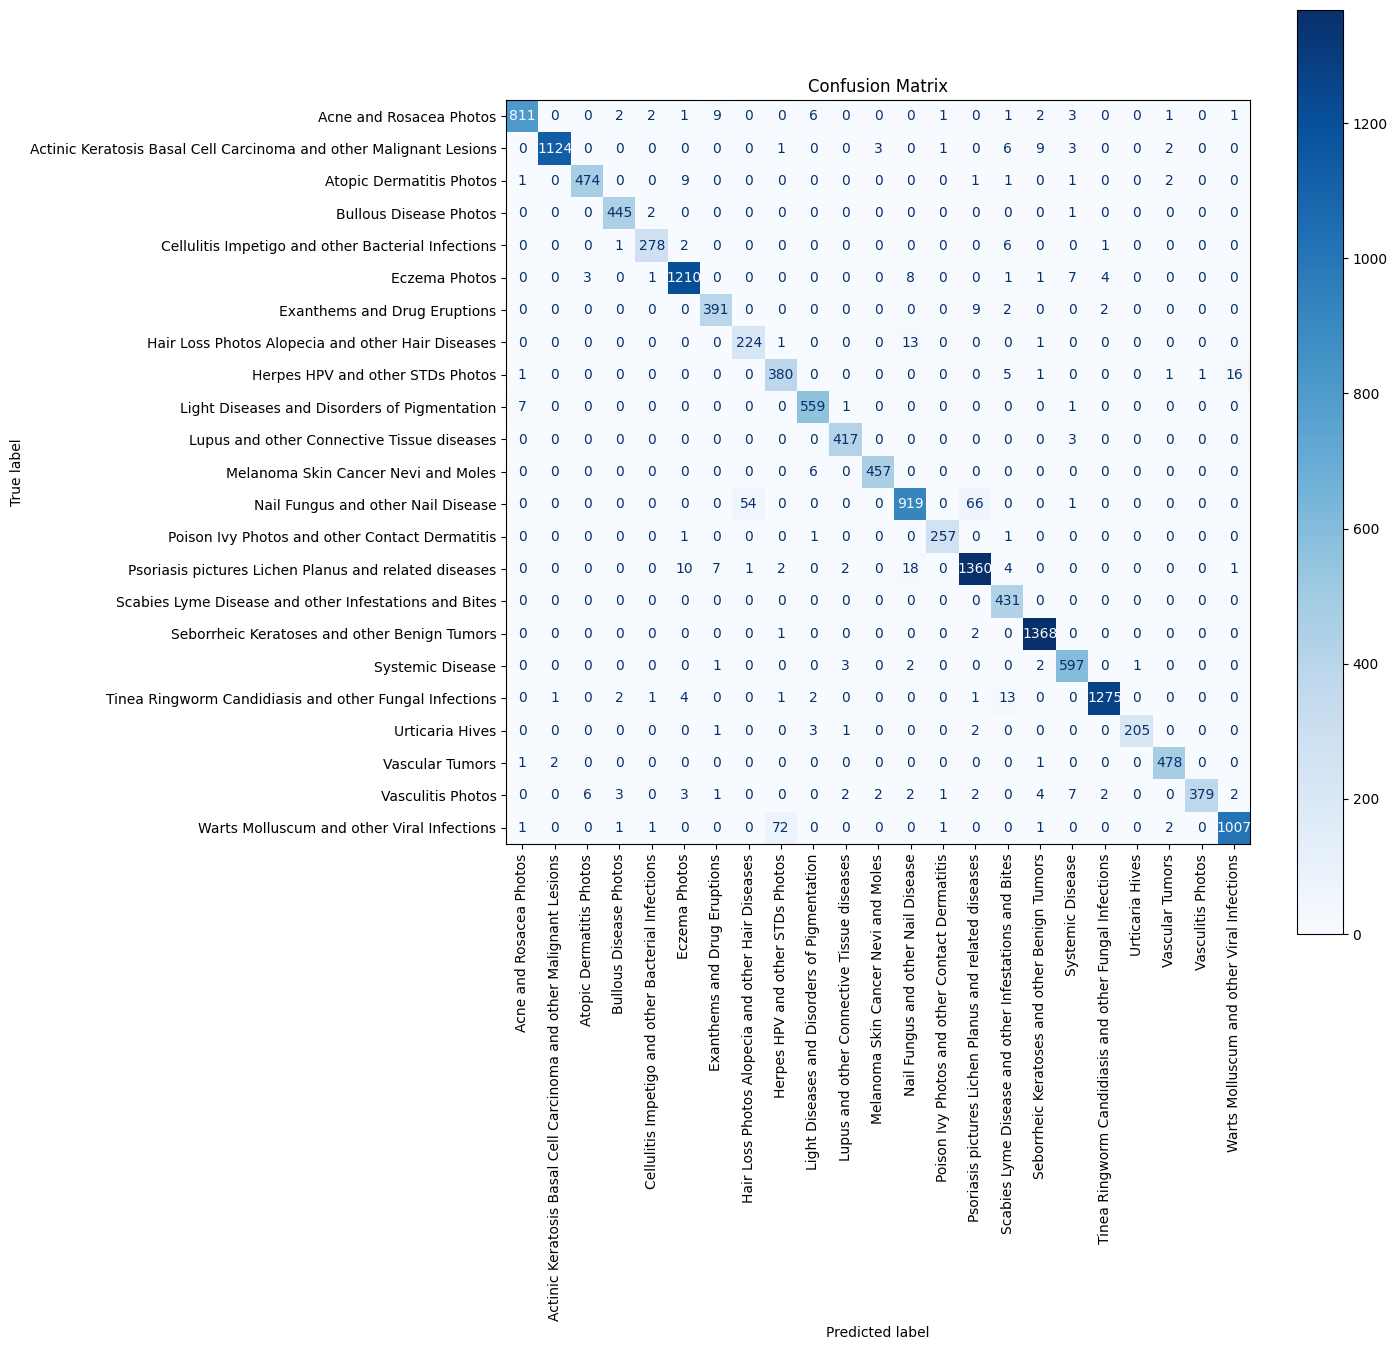

In [ ]:

def plot_confusion_matrix(model, test_loader, class_names, device, weights_path="best_train_model.pth"):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=True)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()
    
plot_confusion_matrix(
    model=model,
    test_loader=test_loader,
    class_names=train_dataset.classes,
    device=device,
    weights_path="best_train_model.pth"
)    

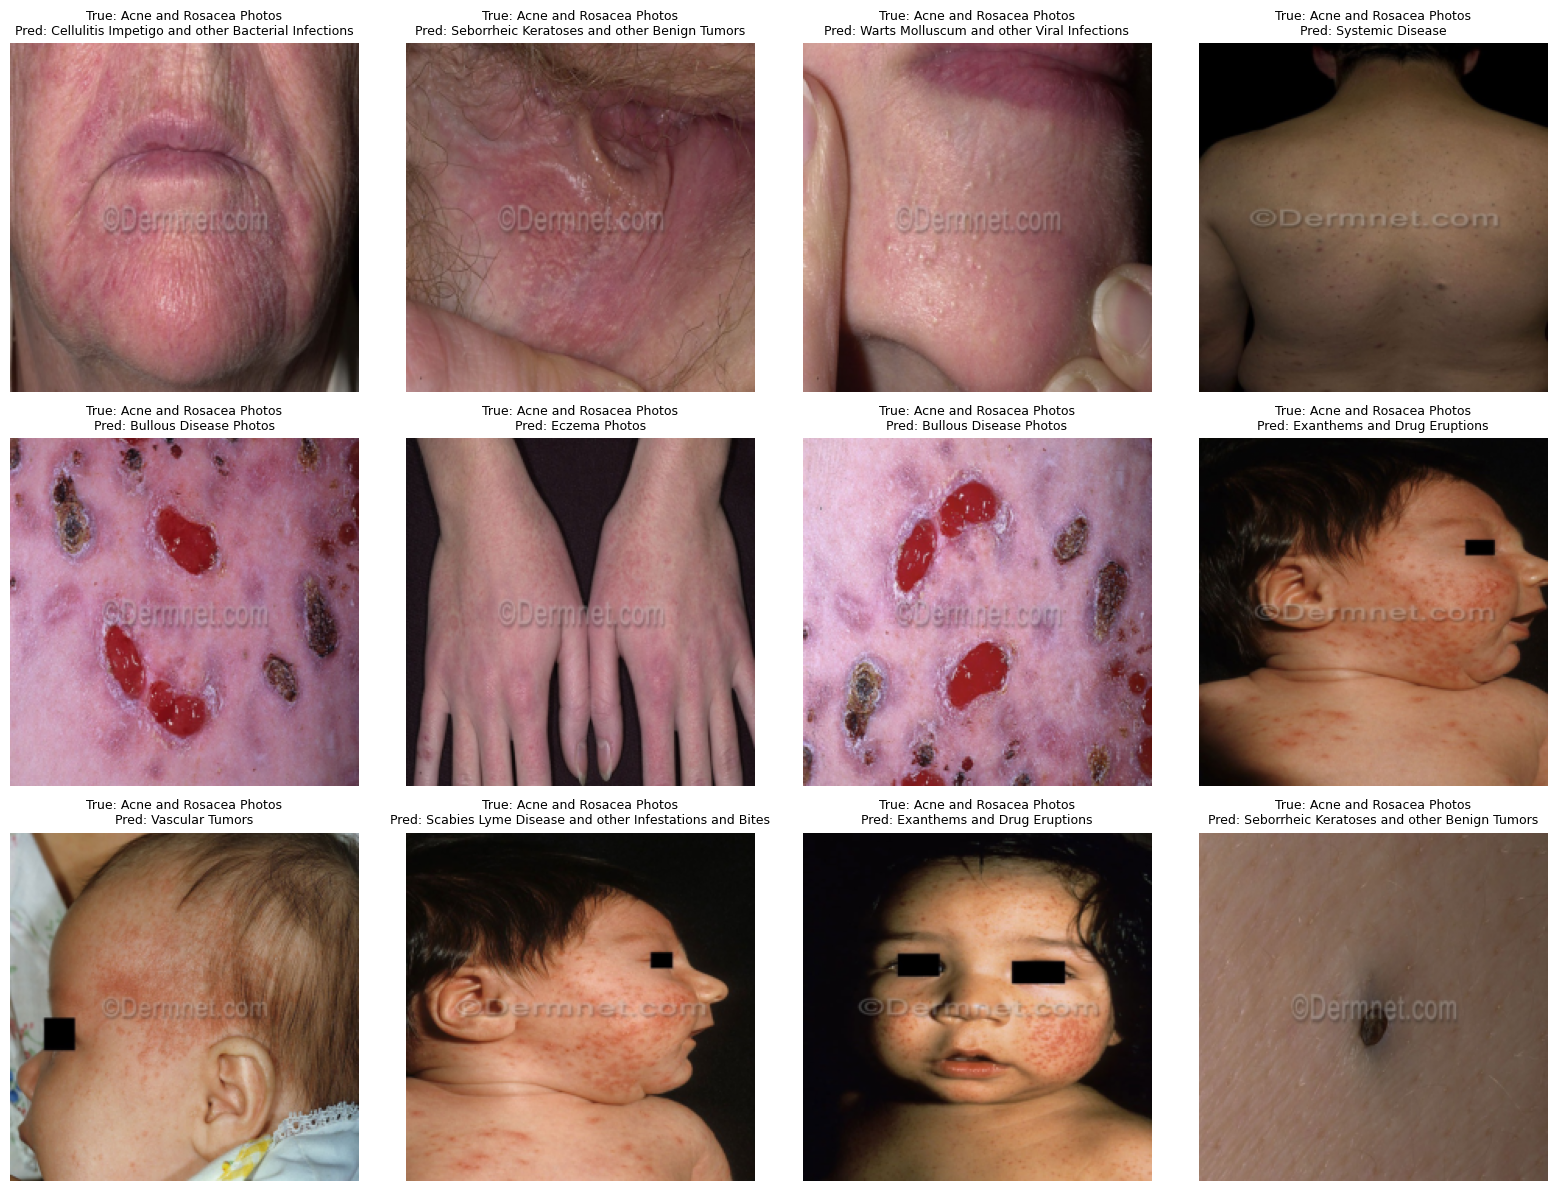

In [ ]:
import matplotlib.pyplot as plt

def show_misclassified(model, test_loader, class_names, device, weights_path="best_train_model.pth", max_images=12):
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()

    errors = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    errors.append((img.cpu(), pred.cpu(), label.cpu()))
                    if len(errors) >= max_images:
                        break
            if len(errors) >= max_images:
                break

    # Affichage
    n = len(errors)
    cols = 4
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    for i, (img, pred, label) in enumerate(errors):
        ax = axes.flat[i]
        img = img.permute(1, 2, 0) * 0.5 + 0.5  # dé-normalisation
        ax.imshow(img)
        ax.set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}", fontsize=9)
        ax.axis('off')

    # Cache les cases vides
    for i in range(n, rows * cols):
        axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()

show_misclassified(
    model=model,
    test_loader=test_loader,
    class_names=train_dataset.classes,
    device=device,
    weights_path="best_train_model.pth",
)    


### Loading the model

In [10]:
import timm
import torch.nn as nn
import torch

# 1. Recréer le modèle avec la bonne architecture
model = timm.create_model('vit_base_patch16_224', pretrained=False)
model.head = nn.Linear(model.head.in_features, 23)  # Remplace 23 par le bon nombre de classes

# 2. Charger les poids
model.load_state_dict(torch.load("best_train_model.pth", map_location=device))
model.to(device)
model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

### Predictive system

In [11]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F

def predict_image_top3(image_path, model, class_names, device, weights_path="best_train_model.pth"):
    # Charger les poids
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()

    # Prétraitement identique à l'entraînement
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    # Charger et transformer l'image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # [1, C, H, W]

    # Prédiction
    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1).squeeze()  # [num_classes]

    # Obtenir le top 3
    top3_probs, top3_indices = torch.topk(probs, 3)

    # Résultats
    results = [(class_names[idx], float(prob)) for idx, prob in zip(top3_indices, top3_probs)]
    top_pred_class, confidence = results[0]

    return top_pred_class, confidence, results


In [15]:
pred_class, confidence, top3 = predict_image_top3(
    image_path="./Hemangioma.jpg",
    model=model,
    class_names=train_dataset.classes,
    device=device
)

print(f"✅ Prédiction : {pred_class} ({confidence*100:.2f} %)")
print("🏆 Top 3 :")
for label, score in top3:
    print(f" - {label}: {score*100:.2f} %")


✅ Prédiction : Tinea Ringworm Candidiasis and other Fungal Infections (79.54 %)
🏆 Top 3 :
 - Tinea Ringworm Candidiasis and other Fungal Infections: 79.54 %
 - Vascular Tumors: 14.47 %
 - Seborrheic Keratoses and other Benign Tumors: 4.23 %
